<a href="https://colab.research.google.com/github/UNB-TME-6017-W24/assignment-2-transfer-learning-for-image-classification-ShriHemaPriya/blob/main/ShriHemaPriya_Ganesan_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Model: ResNet**

Residual Network (ResNet) serves as a deep learning framework used in computer vision tasks. It is a Convolutional Neural Network (CNN) structure crafted to accommodate numerous convolutional layers, potentially reaching hundreds or even thousands.

**Addressed the vanishing gradient problem**
In the domains of deep learning and data science, the vanishing gradient problem is a widely recognized hurdle. This challenge primarily occurs during the training of artificial neural networks that employ backpropagation and gradient-based learning techniques.

As we send the information about how wrong our predictions are (the gradient) backward through all the layers, it gets much smaller with each layer. This shrinking gradient makes the learning process super slow or can even stop it altogether in the early layers, making it hard for the network to learn effectively.

ResNet introduces a unique strategy to tackle the vanishing gradient problem, known as "skip connections". By stacking multiple identity mappings, which initially act as inert convolutional layers, ResNet bypasses these layers and leverages the activations from the previous layer. This skipping mechanism expedites the initial training phase by condensing the network into fewer layers.

**ResNet Types**
1. ResNet 34
2. ResNet 50
3. ResNet 101
4. Resnet 152

**Applications**

**Image Recognition:**
ResNet is really good at recognizing things in pictures, whether it's everyday objects in regular photos or specialized images in different areas. It has shown excellent performance on well-known datasets like ImageNet.

**Object Detection:**
ResNet is often used in systems that find and identify objects in images. It works with detection frameworks like Faster R-CNN, making it better at figuring out what's in an image. This helps improve accuracy in spotting and categorizing objects.

**Video Analysis:**
ResNet can also be used to understand and analyze videos. Its deep design helps process information over time in video frames. People use it in surveillance systems and even in analyzing videos for entertainment purposes.

**Medical Image Analysis:**
In the field of medicine, ResNet plays a vital role in looking at medical images like X-rays, MRIs, and CT scans. It's like a helpful tool for doctors, helping them spot patterns and irregularities that might indicate different health conditions. This is really useful in diagnosing diseases and planning treatments.

**Citation:**
https://www.ikomia.ai/blog/mastering-resnet-deep-learning-image-recognition

In [ ]:
# Try installing the tensorflow-hub module
!pip install tensorflow-hub

In [ ]:
# Import packages
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# Load CIFAR10 data
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [ ]:
#Normalize the pixel values of the images to the range [0, 1]
train_images, test_images = train_images.astype("float32")  / 255, test_images.astype("float32")  / 255

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an image data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Data augmentation
datagen.fit(train_images)

In [ ]:
import numpy as np
def subset(images, labels, fraction=0.1, num_classes=10):
    subset_size = int(len(images) * fraction)
    indices = np.random.choice(len(images), size=subset_size, replace=False)
    subset_images = images[indices]
    subset_labels = labels[indices]
    subset_labels_one_hot = to_categorical(subset_labels, num_classes=num_classes)
    return subset_images, subset_labels_one_hot

# Take 10% of the dataset and perform one hot encoding
train_image_data, train_labels_data = subset(train_images, train_labels)
test_images_data, test_labels_data = subset(test_images, test_labels)

In [ ]:
# Load ResNet model without top layers
model_url = "https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow1/variations/101-classification/versions/2"

resnet_model = tf.keras.Sequential([
    hub.KerasLayer(model_url, input_shape=(224, 224, 3), trainable=False)
])

In [ ]:
# Freeze ResNet layers
for layer in resnet_model.layers:
    layer.trainable = False

In [ ]:
# Add custom layers for CIFAR10 classification
x = Dense(1024, activation='relu')(resnet_model.output)
output = Dense(10, activation='softmax')(x)

# Create the final model
model = Model(inputs=resnet_model.input, outputs=output)

In [ ]:
# View the ResNet Architecture
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5_input (Input  [(None, 224, 224, 3)]     0         
 Layer)                                                          
                                                                 
 keras_layer_5 (KerasLayer)  (None, 1001)              44677609  
                                                                 
 dense_8 (Dense)             (None, 1024)              1026048   
                                                                 
 dense_9 (Dense)             (None, 10)                10250     
                                                                 
Total params: 45713907 (174.38 MB)
Trainable params: 1036298 (3.95 MB)
Non-trainable params: 44677609 (170.43 MB)
_________________________________________________________________


In [ ]:
# Resize images to preprocess the data
def resize(images,label):
  images = tf.image.resize(images, (224,224))
  images = images/255.0
  return images,label


In [ ]:
# Splitting training dataset into training and validation sets
train_images, images_val, train_labels, labels_val = train_test_split(train_image_data, train_labels_data, test_size=0.2, random_state=42)

#Slices the datasets
train_data = tf.data.Dataset.from_tensor_slices((train_image_data, train_labels_data))
val_data = tf.data.Dataset.from_tensor_slices((images_val, labels_val))
test_data = tf.data.Dataset.from_tensor_slices((test_images_data, test_labels_data))

# Apply the batch, and prefetch
train_data = train_data.map(resize).batch(32).prefetch(tf.data.AUTOTUNE)
val_data = val_data.map(resize).batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(resize).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
batch_size = 32
epochs = 10
learning_rate = 0.0001

# Prepare the learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate,
    decay_steps=(train_images.shape[0] // batch_size) * epochs,
    decay_rate=0.96,
    staircase=True)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Train the model
global trainedmodel
trainedmodel = model.fit(
    train_data,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = val_data
)

Epoch 1/10
157/157 [==============================] - 33s 196ms/step - loss: 2.1182 - accuracy: 0.2258 - val_loss: 2.0607 - val_accuracy: 0.2620
Epoch 2/10
157/157 [==============================] - 29s 183ms/step - loss: 2.0716 - accuracy: 0.2498 - val_loss: 2.0184 - val_accuracy: 0.2780
Epoch 3/10
157/157 [==============================] - 29s 183ms/step - loss: 2.0373 - accuracy: 0.2602 - val_loss: 1.9848 - val_accuracy: 0.2970
Epoch 4/10
157/157 [==============================] - 30s 192ms/step - loss: 2.0099 - accuracy: 0.2722 - val_loss: 1.9572 - val_accuracy: 0.3040
Epoch 5/10
157/157 [==============================] - 29s 184ms/step - loss: 1.9875 - accuracy: 0.2798 - val_loss: 1.9362 - val_accuracy: 0.3110
Epoch 6/10
157/157 [==============================] - 29s 185ms/step - loss: 1.9683 - accuracy: 0.2862 - val_loss: 1.9154 - val_accuracy: 0.3140
Epoch 7/10
157/157 [==============================] - 29s 185ms/step - loss: 1.9511 - accuracy: 0.2922 - val_loss: 1.8973 - val_ac

In [ ]:
#Evaluate the model on the CIFAR10 test set and report the accuracy.
score = model.evaluate(test_data)
#Print the loss and accuracy
print('Test loss:', score[0])
print('Test accuracy:', score[1])

32/32 [==============================] - 5s 148ms/step - loss: 1.9392 - accuracy: 0.3020
Test loss: 1.93923020362854
Test accuracy: 0.3019999861717224


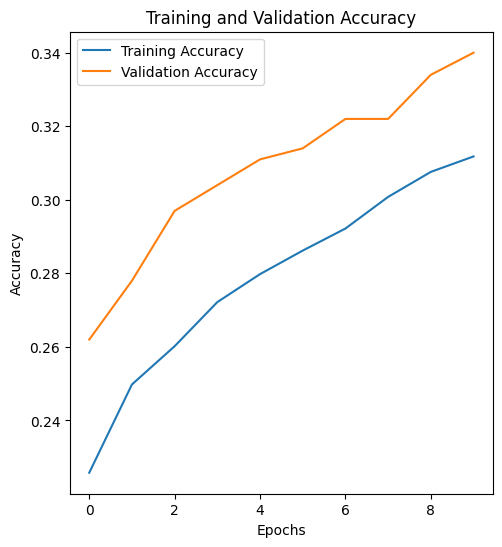

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(trainedmodel.history['accuracy'], label='Training Accuracy')
plt.plot(trainedmodel.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()



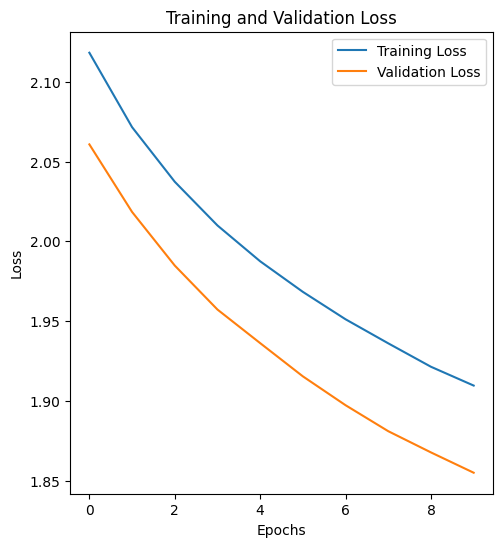

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(trainedmodel.history['loss'], label='Training Loss')
plt.plot(trainedmodel.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

**Result Observation:**

I have got less accuracy even after fine tuning. Changed the learning rate to 0.0001, used data augmentation, added dense layers of relu and softmax to increase the accuracy by changing the CNN architecture. Since my system carshed when I try to resize to 224,224 the whole dataset. So, I have used 10% of CIFAR 10 dataset and resized 224, 224 to avoid system crash problem.

Also, I have tried to increase the epochs from 5 to 10 and batch size but the accuracy did not increase. The overall accuracy is 31% which is not a best one.

There is no overfitting or underfitting by observing the plots for training and validation accuracy, training and validation loss. Both the training accuracy and validation accuracy are gradually increasing whereas the training loss and validation loss are gradually decreasing.

We may use different pre trained model like efficient net, mobile net with appropriate parameters to get a good accuracy.
